# Causal Inference with DoWhy — Hotel Booking Cancellations

## Introduction
In this notebook we estimate the **causal effect** of assigning a customer
a different room than reserved on the probability that they cancel a hotel
booking. We use the DoWhy library for structured causal analysis.

# Why this problem?
- Experimental data (true random assignments) are unavailable.
- We only have historical observations (observational data).
- We want to leverage domain knowledge + causal graphs to answer:
      “Does assigning a different room *cause* more cancellations?”
- The steps follow DoWhy’s four-step causal inference process.

In [1]:
# Required libraries
!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2024\Session_6\venv_apps\Scripts\python.exe -m pip install --upgrade pip


c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1) Data Loading & Preprocessing

## Explanation:
We create meaningful variables:

- **different_room_assigned**: the treatment.

- **is_canceled**: the outcome.

Other columns become either confounders or auxiliary features.

In [19]:
# Load the hotel bookings dataset (Tidytuesday version)
dataset = pd.read_csv(
    "https://raw.githubusercontent.com/Sid-darthvader/"
    "DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/"
    "hotel_bookings.csv"
)

# Create derived features
dataset['total_stay'] = (dataset['stays_in_weekend_nights'] +
                         dataset['stays_in_week_nights'])
dataset['guests'] = (dataset['adults'] +
                     dataset['children'] +
                     dataset['babies'])

# Treatment: Whether the assigned room type differs from the reserved room
dataset['different_room_assigned'] = (
    dataset['reserved_room_type'] != dataset['assigned_room_type']
)

# Convert booleans for DoWhy
dataset['different_room_assigned'] = dataset['different_room_assigned'].astype(bool)
dataset['is_canceled'] = dataset['is_canceled'].astype(bool)

# Drop irrelevant columns and missing values
dataset = dataset.drop(
    ['agent', 'company', 'reservation_status', 'reservation_status_date'],
    axis=1
).dropna()

dataset.head()


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,2015,July,27,1,0,0,2,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,2015,July,27,1,0,0,2,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,2015,July,27,1,0,1,1,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,2015,July,27,1,0,1,1,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,2015,July,27,1,0,2,2,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


# 2) Define Causal Assumptions via a Causal Graph

## Why we need a causal graph

Before estimating any causal effect, we must be explicit about our assumptions on how the data were generated. In causal inference, these assumptions are encoded in a Directed Acyclic Graph (DAG).

The DAG serves three purposes:

1) It makes our causal assumptions explicit and transparent.

2) It allows us to determine whether the causal effect of interest is identifiable from observational data.

3) It guides the choice of variables we need to adjust for (confounders).

Our causal question is:
'''
**What is the causal effect of assigning a different room than reserved on the probability that a booking is cancelled?**
'''

- Treatment (T): different_room_assigned

- Outcome (Y): is_canceled

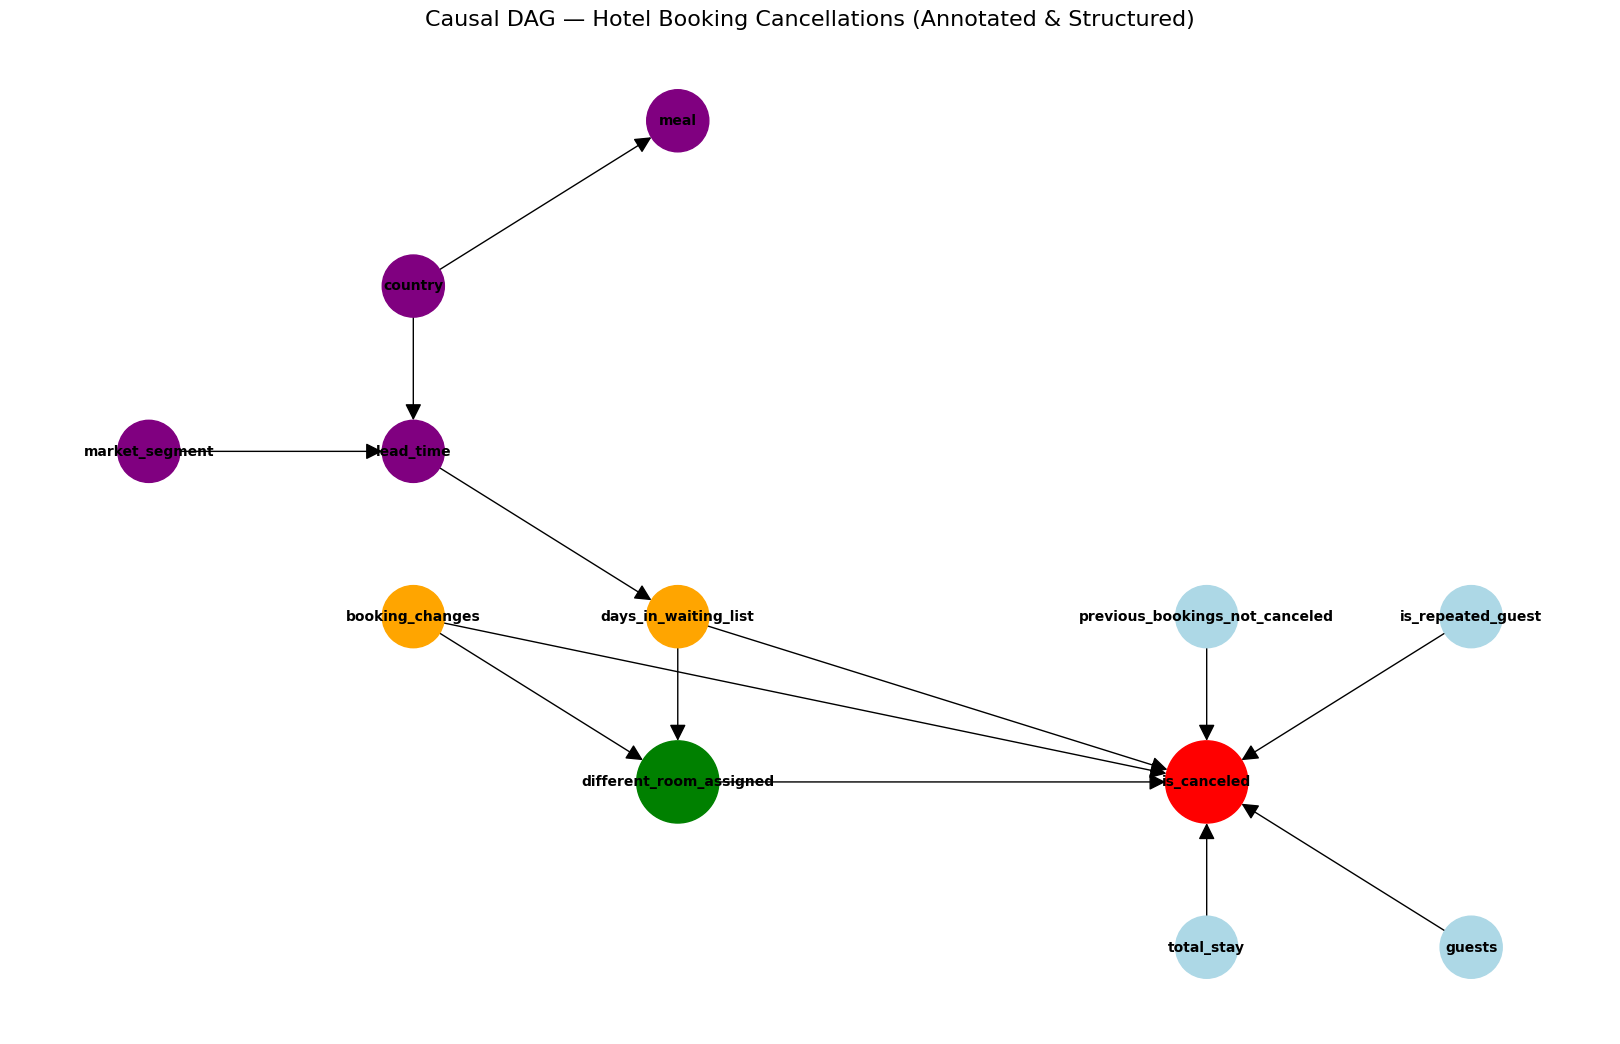

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from dowhy import CausalModel

# Create DAG
causal_graphNX = nx.DiGraph([
    # Unobserved confounder
    #('U', 'different_room_assigned'),
    #('U', 'is_canceled'),

    # Treatment → Outcome
    ('different_room_assigned', 'is_canceled'),

    # Confounding through booking behavior
    ('booking_changes', 'different_room_assigned'),
    ('booking_changes', 'is_canceled'),

    # Waiting list mechanism
    ('lead_time', 'days_in_waiting_list'),
    ('days_in_waiting_list', 'different_room_assigned'),
    ('days_in_waiting_list', 'is_canceled'),

    # Customer history / experience
    ('previous_bookings_not_canceled', 'is_canceled'),
    ('is_repeated_guest', 'is_canceled'),

    # Stay characteristics
    ('total_stay', 'is_canceled'),
    ('guests', 'is_canceled'),

    # Market & demographics
    ('market_segment', 'lead_time'),
    ('country', 'lead_time'),
    ('country', 'meal')
])

# Node color coding
node_colors = {}
for node in causal_graphNX.nodes():
    if node == 'different_room_assigned':
        node_colors[node] = 'green'   # Treatment
    elif node == 'is_canceled':
        node_colors[node] = 'red'     # Outcome
    elif node == 'U':
        node_colors[node] = 'gray'    # Unobserved confounder
    elif node in ['booking_changes', 'days_in_waiting_list']:
        node_colors[node] = 'orange'  # Confounders
    elif node in ['previous_bookings_not_canceled', 'is_repeated_guest',
                  'total_stay', 'guests']:
        node_colors[node] = 'lightblue' # Outcome-only covariates
    elif node in ['lead_time', 'market_segment', 'country', 'meal']:
        node_colors[node] = 'purple'  # Upstream demographic/market
    else:
        node_colors[node] = 'lightgrey'  # default

# Node sizes
node_sizes = {}
for node in causal_graphNX.nodes():
    if node in ['different_room_assigned', 'is_canceled']:
        node_sizes[node] = 3500
    elif node == 'U':
        node_sizes[node] = 2500
    else:
        node_sizes[node] = 2000

# Layout manually to match explanation
pos = {
    # Center treatment & outcome
    'different_room_assigned': (0, 0),
    'is_canceled': (2, 0),

    # Unobserved confounder off to the left
    'U': (-2, 0),

    # Confounders near treatment & outcome
    'booking_changes': (-1, 1),
    'days_in_waiting_list': (0, 1),
    'lead_time': (-1, 2),

    # Customer history / experience above outcome
    'previous_bookings_not_canceled': (2, 1),
    'is_repeated_guest': (3, 1),

    # Stay characteristics below outcome
    'total_stay': (2, -1),
    'guests': (3, -1),

    # Market & demographics above lead_time
    'market_segment': (-2, 2),
    'country': (-1, 3),
    'meal': (0, 4)
}

# 3) Build the DoWhy causal model using the NetworkX DAG
model = CausalModel(
    data=dataset,
    graph=causal_graphNX,   # <-- pass the NetworkX graph directly
    treatment="different_room_assigned",
    outcome="is_canceled"
)

plt.figure(figsize=(16, 10))
nx.draw(
    causal_graphNX,
    pos,
    with_labels=True,
    node_color=[node_colors[n] for n in causal_graphNX.nodes()],
    node_size=[node_sizes[n] for n in causal_graphNX.nodes()],
    font_size=10,
    font_weight='bold',
    arrowsize=25
)
plt.title("Causal DAG — Hotel Booking Cancellations (Annotated & Structured)", fontsize=16)
plt.show()

## Explanation of Key Components from the graph

### 1. Treatment → Outcome

**different_room_assigned → is_canceled**

This arrow represents the **causal effect we want to estimate**.

**Interpretation:**  
Assigning a room different from the one originally reserved may affect customer satisfaction, which in turn can influence whether the booking is cancelled.

Importantly, this arrow does **not** assume the effect is positive or negative — it only encodes the assumption that a causal relationship is plausible.

---

### 2. Confounding Through Booking Behavior

**booking_changes → different_room_assigned**  
**booking_changes → is_canceled**

`booking_changes` is a **classic confounder**.

Customers who frequently modify their bookings are:

- More likely to end up with a different room (due to availability changes)
- More likely to cancel altogether

If we do **not** adjust for `booking_changes`, we may incorrectly attribute the effect of unstable booking behavior to the room assignment itself.

This creates a **backdoor path** that must be blocked to identify the causal effect.

---

### 3. Waiting List Mechanism (Structural Confounding)

**lead_time → days_in_waiting_list**  
**days_in_waiting_list → different_room_assigned**  
**days_in_waiting_list → is_canceled**

This subgraph captures an **operational mechanism** of hotel management:

- Longer lead times increase the probability of being placed on a waiting list.
- Being on a waiting list:
  - Increases the likelihood of room reassignment
  - Increases uncertainty, which raises cancellation probability

This structure shows how **operational constraints**, not just customer dissatisfaction, can jointly influence both the treatment and the outcome.

---

### 4. Customer History and Experience

**previous_bookings_not_canceled → is_canceled**  
**is_repeated_guest → is_canceled**

These variables capture **customer reliability and loyalty**:

- Customers with a history of honoring bookings are less likely to cancel.
- Repeated guests tend to be more predictable and forgiving.

They affect the outcome but not the treatment, so they are **not confounders**.  
However, adjusting for them can improve **estimation efficiency**.

---

### 5. Stay Characteristics

**total_stay → is_canceled**  
**guests → is_canceled**

Longer stays and larger groups represent higher cost and coordination effort:

- Longer stays may increase cancellation risk due to greater uncertainty.
- Larger groups may cancel more often due to coordination difficulties.

These variables influence cancellation behavior but do not plausibly affect room reassignment decisions directly.

---

### 6. Market and Demographic Structure

**market_segment → lead_time**  
**country → lead_time**  
**country → meal**

These variables capture **systematic heterogeneity** in booking behavior:

- Different market segments book with different anticipation times.
- Country of origin affects booking preferences and habits.

They primarily influence **upstream variables** (such as lead time), rather than directly affecting the treatment or outcome.
This is an upstream variable that is blocked if we control for **lead_time** 

---

### 7. Unobserved Confounding (optional)

**U → different_room_assigned**  
**U → is_canceled**

The unobserved node `U` represents factors we cannot measure, such as:

- Individual expectations
- Travel purpose urgency
- Price sensitivity

Including `U` explicitly acknowledges that causal inference always relies on **assumptions**, and that some confounding may remain unmeasured.

---

## Why This Graph Is Reasonable

This DAG is:

- **Domain-informed**: it reflects hotel operations and customer behavior
- **Minimal**: it avoids unnecessary arrows that would weaken identifiability
- **Testable**: it leads to clear adjustment sets via the backdoor criterion

## Parameters Left Out and Why

Not every variable in the hotel bookings dataset is included in our causal graph. Here's what we left out and the reasoning:

- **Administrative IDs:** `agent`, `company` → These do not influence treatment or outcome.
- **Post-treatment variables:** `reservation_status`, `reservation_status_date` → Including these could **introduce post-treatment bias**.
- **Redundant or aggregated features:** 
  - `adults`, `children`, `babies` → combined into `guests`.
  - `stays_in_weekend_nights`, `stays_in_week_nights` → combined into `total_stay`.
  - `assigned_room_type` → summarized as `different_room_assigned` (our treatment).
- **Other operational details:** Variables like payment type, special requests, or exact arrival date → either post-treatment, redundant, or not plausibly causally affecting both treatment and outcome.

**Takeaway:** Only include variables that are **confounders, treatment predictors, outcome predictors, or part of the structural causal mechanism**. Everything else can safely be left out to keep the DAG clear and avoid bias.

---

## Key Teaching Points from This DAG

Dear student, here’s why this causal graph is designed the way it is:

1. **Focus on domain knowledge:** The DAG reflects hotel operations and customer behavior, making causal assumptions plausible and interpretable.
2. **Backdoor paths are explicit:** Confounders like `booking_changes` and `days_in_waiting_list` are included so you can see exactly which variables need to be adjusted for.
3. **Treatment and outcome are clearly highlighted:** `different_room_assigned` (green) and `is_canceled` (red) are at the center of the graph for clarity.
4. **Unobserved confounding is acknowledged:** `U` represents factors we cannot measure, reminding you that causal inference always relies on assumptions.
5. **Minimal but sufficient:** The graph avoids unnecessary arrows, focusing on variables that are essential for estimating the causal effect accurately.
6. **Clarity over completeness:** Simplifying the DAG helps you learn and apply causal reasoning before considering additional variables.

**Remember:** The goal is to understand **how to identify and estimate causal effects**, not to include every dataset column. Focus on confounders and structural mechanisms first!

## 3) Identify the Causal Effect

In [25]:
# This step uses the backdoor criterion based on the DAG
identified_estimand = model.identify_effect()
print("Estimated adjustment set:", identified_estimand.get_backdoor_variables())

Estimated adjustment set: ['booking_changes', 'days_in_waiting_list']


## 4) Estimate Causal Effect

In [27]:
# Example: using linear regression for simplicity
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Effect of Different Room Assigned on Cancellation:")
print(causal_estimate)

Causal Effect of Different Room Assigned on Cancellation:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                  
──────────────────────────(E[is_canceled|booking_changes,days_in_waiting_list])
d[different_room_assigned]                                                     
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,days_in_waiting_list,U) = P(is_canceled|different_room_assigned,booking_changes,days_in_waiting_list)

## Realized estimand
b: is_canceled~different_room_assigned+booking_changes+days_in_waiting_list+different_room_assigned*guests+different_room_assigned*previous_bookings_not_canceled+different_room_assigned*total_stay+different_room_assigned*is_repeated_guest
Target units: 

## Estimate
Mean 

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:

# Interpretation of Causal Estimate

## 1 Type of Estimand

**Estimand type:** `EstimandType.NONPARAMETRIC_ATE`

- **ATE = Average Treatment Effect**  
- **Nonparametric:** We do not assume a specific functional form for the relationship between variables; we rely on **conditioning on confounders only**.

**In simple terms:**  
> On average, how does assigning a different room affect the probability of cancellation?

---

## 2 Identified Estimand (Backdoor Formula)

\[
\frac{d}{d[\text{different\_room\_assigned}]} \mathbb{E}[ \text{is\_canceled} \mid \text{booking\_changes}, \text{days\_in\_waiting\_list} ]
\]

This is the **backdoor adjustment formula**:  

- We are estimating the causal effect of `different_room_assigned` on `is_canceled` **while conditioning on the observed confounders**:  
  - `booking_changes`  
  - `days_in_waiting_list`  

- **Assumption:** no unobserved confounders remain (we removed `U` in the simplified DAG).  

**Interpretation:**  
> Compare the expected cancellation rate between customers who were assigned a different room vs. not, **after accounting for booking changes and waiting list days**.

---

## 3️ Realized Estimand (Regression Model)

```text
is_canceled ~ different_room_assigned + booking_changes + days_in_waiting_list 
             + different_room_assigned*guests
             + different_room_assigned*previous_bookings_not_canceled
             + different_room_assigned*total_stay
             + different_room_assigned*is_repeated_guest
```

Explanation:

- different_room_assigned → main treatment effect

- booking_changes + days_in_waiting_list → control variables (adjustment set)

Interactions with outcome-only covariates (guests, previous_bookings_not_canceled, total_stay, is_repeated_guest) → improve estimation efficiency but are not required for identification

In other words, the model estimates the treatment effect while controlling for confounders and improving precision using outcome predictors.

## 4 Estimate: Mean Value

- Mean ATE: -0.3371

Interpretation:

- Assigning a different room reduces the probability of cancellation by ~33.7 percentage points, on average, after adjusting for confounders.
Rewrite the following text in proper markdown language in a text of a markdown file (.md)



## 3️ Realized Estimand (Regression Model)

```text

is_canceled ~ different_room_assigned + booking_changes + days_in_waiting_list 

             + different_room_assigned*guests

             + different_room_assigned*previous_bookings_not_canceled

             + different_room_assigned*total_stay

             + different_room_assigned*is_repeated_guest

```

Explanation:

- different_room_assigned → main treatment effect

- booking_changes + days_in_waiting_list → control variables (adjustment set)

Interactions with outcome-only covariates (guests, previous_bookings_not_canceled, total_stay, is_repeated_guest) → improve estimation efficiency but are not required for identification

In other words, the model estimates the treatment effect while controlling for confounders and improving precision using outcome predictors.

## 4 Estimate: Mean Value

- Mean ATE: -0.3371

Interpretation:

- Assigning a different room reduces the probability of cancellation by ~33.7 percentage points, on average, after adjusting for confounders.

- Negative sign → protective effect (fewer cancellations).

Caution: This is based on the simplified DAG without the unobserved confounder U. In real-world data, unobserved factors could bias this estimate.

## 5 Conditional Estimates (Heterogeneity)

DoWhy reports how the treatment effect varies conditional on outcome predictors:

| guests  | previous_bookings_not_canceled | total_stay | is_repeated_guest | estimate |
|--------|-------------------------------|------------|-----------------|---------|
| (0,2]  | (0,72]                        | (0,2]      | 0               | -0.3558 |
| ...    | ...                            | ...        | ...             | ...     |

# Example interpretation:

For a customer with low guest count, low booking reliability, short stay, and not a repeated guest, assigning a different room reduces cancellation probability by ~35.6%.

The table highlights heterogeneity in treatment effects:

| guests  | previous_bookings_not_canceled | total_stay | is_repeated_guest | estimate |
|--------|-------------------------------|------------|-----------------|---------|
| (0,2]  | (0,72]                        | (0,2]      | 0               | -0.3558 |
| ...    | ...                            | ...        | ...             | ...     |


# Example interpretation:

For a customer with low guest count, low booking reliability, short stay, and not a repeated guest, assigning a different room reduces cancellation probability by ~35.6%.

The table highlights heterogeneity in treatment effects:

Some subgroups experience a slightly stronger or weaker effect depending on customer history or stay characteristics.


In [ ]:
# Example: include observed covariates manually in regression (using unobserved confounder!)
#causal_estimate = model.estimate_effect(
#    identified_estimand,
#    method_name="backdoor.linear_regression",
#    control_value=None,
#    treatment_value=None,
#    target_units="all",  # full dataset
#    method_params={
#        "linear_regression_model": "ols",  # default
#        "covariates": ["booking_changes", "days_in_waiting_list"]
#    }
#)


## 6) Refute / Validate the estimate

In [28]:
# 6a) Placebo (randomly permute treatment)
refute1 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="placebo_treatment_refuter"
)
print(refute1)

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:

Refute: Use a Placebo Treatment
Estimated effect:-0.33710860091226347
New effect:7.852447417776298e-05
p value:0.94



c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:

# Interpretation:

The placebo test randomly permutes the treatment assignment.

If the model is valid, a random treatment should have no effect on the outcome.

- Observed result: effect ≈ 0 (7.85e-05), and high p-value (0.94) → no significant effect.

Conclusion: The model is not producing spurious effects due to random chance or model misspecification.

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\numpy\_core\fromnumeric.py:3800: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_refuters\add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

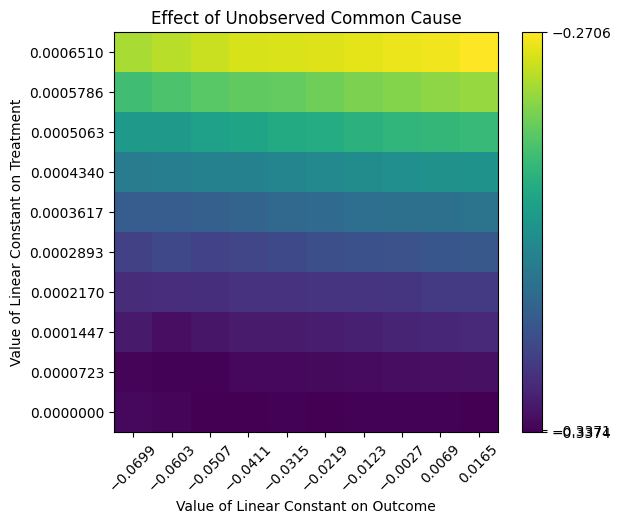

Refute: Add an Unobserved Common Cause
Estimated effect:-0.33710860091226347
New effect:(np.float64(-0.3374268783580364), np.float64(-0.2705861614262494))



In [29]:
# 6b) Add unobserved confounder refuter
refute2 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="add_unobserved_common_cause",
    confounder_strength=0.1  # small confounding
)
print(refute2)

# Interpretation:

This refuter simulates what happens if an unobserved confounder exists.

- The effect slightly shrinks but remains negative: -0.34 → -0.27 (worst case).

This indicates that the estimated effect is somewhat robust to unobserved confounding, but could be weaker if strong unobserved confounders exist.

Conclusion: The result supports robustness, but highlights that unobserved confounders could reduce the effect size.

In [30]:
# 6c) Data subset refuter
refute3 = model.refute_estimate(
    identified_estimand,
    causal_estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.8
)
print(refute3)

c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:

Refute: Use a subset of data
Estimated effect:-0.33710860091226347
New effect:-0.33721689950072414
p value:0.88



c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
c:\Users\Bertram Taetz\gitRepos\DLMAIIAC\Sprint_November_2025\Session_6\venv_apps\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:

# Interpretation:

The effect is estimated on a random 80% subset of the data.

The effect remains almost identical: -0.3371 → -0.3372.

High p-value → no significant change.

Conclusion: The effect is stable and not driven by a small subset of observations.

# Overall Interpretation Summary

1. **Placebo Treatment:** Randomizing the treatment gives an effect near zero (p=0.94), confirming that the original estimate is **not a spurious correlation**.

2. **Add Unobserved Confounder:** Simulating an unobserved confounder slightly reduces the effect (from -0.34 to between -0.34 and -0.27), showing that the estimate is **reasonably robust**, but sensitive to strong hidden confounding.

3. **Data Subset:** Using 80% of the data produces almost the same effect (-0.3372), indicating that the causal estimate is **stable and not driven by a particular subset of customers**.

**Overall:** The estimated causal effect of assigning a different room on cancellation is **negative (~33%) and robust** across multiple refuter tests. While unobserved confounding could weaken it slightly, the result appears reliable and meaningful for understanding hotel booking behavior.